# Trabalho Final - Álbegra Linear Algorítmica

## Tópico: Transformações Lineares em Arquivos de Imagem 

---
Nome: Gabriel Santos Schuina

DRE: 121056295

---

O objetivo desde trabalho é explorar os conceitos de transformações lineares e a manipulação de arquivos de imagens para visulizar o efeitos das transformações de **Rotação**, **Reflexão**, **Esticamento**, **Cisalhamento**. A estrutura desse projeto seguirá os seguintes tópicos:

1. Transformações Lineares

    1.1 Esticamento

    1.2 Rotação

    1.3 Reflexão 

    1.4 Cisalhamento

2. Aplicações Extras

    2.1 Esticamento com Interpolação Bilinear

    2.1 Escala Cinza

    2.2 Reflexão com diagonalização

In [1]:
# bibliotecas e funções utilizadas no projeto
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from math import ceil, sqrt
from uteis import *

Para efeito de visualização inicial, abaixo está representada a imagem a qual sofrerá as transformações lineares durante esse trabalho. A escolha dessa imagem foi feita com base nas aulas da disciplina de Álgebra Linear, na qual a letra "J" foi uma imagem muito bem utilizada para visualizar o efeito das transformações lineares, uma vez que ela é uma imagem assimétrica, então é facilmente reconhecível os efeitos das transformações.

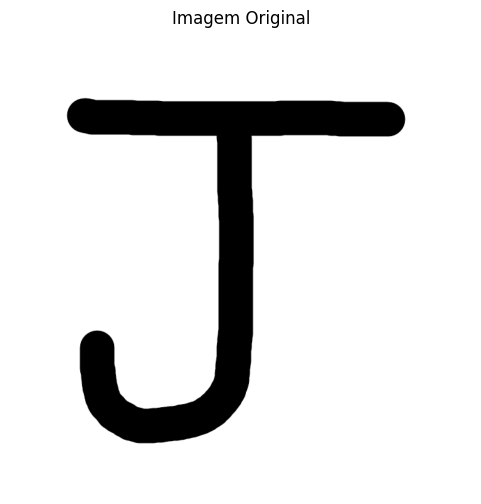

In [2]:
# Carregando e exibindo a imagem original
imagemOriginal = carregarImagem("images/j.png")
exibirImagem(imagemOriginal, "Imagem Original", (6, 6))


### 1. Transformações Lineares

#### 1.1 Esticamento

A transformação de esticamento traz ideia de esticar ou comprimir as dimensões de uma imagem. Matemáticamente essa transformação é definida pela matriz a seguir:

$$
E = \begin{pmatrix}
k_x & 0 \\
0 & k_y
\end{pmatrix}
$$

Nessa matriz os fatores $kx$ e $ky$ representam, respectivamente, os fatores de redimensionamento nos eixos x e y

In [3]:
# transformação de esticamento
def redimensionarImagem(imagem: np.ndarray, kx: float, ky: float, ehColorido: bool) -> np.ndarray:
    '''
    Função que recebe a matriz de uma imagem, os fatores de esticamento/encolhimento kx e ky, e um
    booleano indicando se a imagem é colorida ou não, e realiza o redimensionamento da imagem.
    '''
    # matriz de esticamento
    E = np.array([[kx, 0],
                  [0, ky]])
    
    # estruturamos a matriz transformada
    numLinhas, numColunas = imagem.shape[:2]

    numLinhasNovo = ceil(numLinhas * ky)
    numColunasNovo = ceil(numColunas * kx)
    
    if ehColorido:
        matrizEsticada = np.full((numLinhasNovo, numColunasNovo, imagem.shape[2]), (255, 255, 255, 0), dtype=imagem.dtype)
    else:
        matrizEsticada = 255 * np.ones((numLinhasNovo, numColunasNovo), dtype=imagem.dtype)

    # aplicamos a transformação a cada pixel
    for y in range(numLinhas):
        for x in range(numColunas):
            # armazenamos a informação da cor
            pixel = imagem[y, x]
            # criamos o vetor v com as coordenadas do pixel
            v = np.array([x, y])
            # r é o resultado do esticamento aplicado em v
            r = E @ v
            # convertemos as novas coordenadas para inteiro
            novaLinha, novaColuna = int(r[1]), int(r[0])
            # para garantir que as coordenadas estejam dentro dos limites
            novaLinha = np.clip(novaLinha, 0, numLinhasNovo - 1)
            novaColuna = np.clip(novaColuna, 0, numColunasNovo - 1)
            # colocamos o pixel na nova coordenada
            matrizEsticada[novaLinha, novaColuna] = pixel

    return matrizEsticada

Abaixo o resultado da Transformação de Esticamento em 2x na horizontal da imagem original. Note que a imagem esticada resultante já apresentada alguns problemas relacionados a pixels vazios. Isso é devido a forma como o esticamento está sendo feito computacionalmente, uma vez que a imagem resultante é de fato o dobro do tamanho da imagem original e como os pontos são finitos no computador, muitos pontos da imagem final não tiveram pontos da imagem original para os atingirem. Esse fato é um problema a qual será melhor abordado nos Extras desse trabalho.

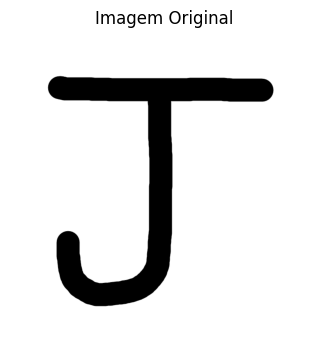

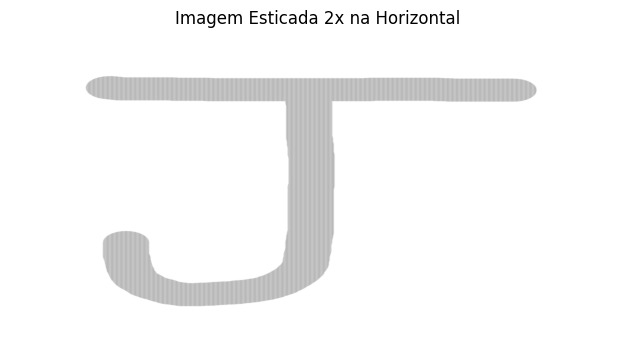

In [4]:
imagemEsticada = redimensionarImagem(imagemOriginal, 2, 1, True)
salvarImagem(imagemEsticada, "results/j_streched.png")
exibirImagem(imagemOriginal, "Imagem Original", (4,4))
exibirImagem(imagemEsticada, "Imagem Esticada 2x na Horizontal", (8, 4))

#### 1.2 Rotação

A transformação de Rotação está associada ao giro de $\theta$ graus de um determinado vetor. No nosso caso, toda a imagem será rotacionada $\theta$ graus no sentido anti-horário. A matriz relacionada a essa transformação é a seguinte:

$$
Rot = \begin{pmatrix}
\cos(\theta) & \sin(\theta) \\
-\sin(\theta) & \cos(\theta)
\end{pmatrix}
$$


In [5]:
# transformação de rotação
def rotacionarImagem(imagem: np.ndarray, angulo: float, ehColorido: bool) -> np.ndarray:
    '''
    Função que recebe uma matriz representando uma imagem, um angulo e um booleano indicando
    se a imagem é colorida ou não e realiza a rotação dessa imagem.
    '''
    # matriz de rotação
    angulo = np.radians(angulo)     # convertemos o angulo de graus para radiano
    Rot = np.array([[np.cos(angulo),  np.sin(angulo)],
                    [-np.sin(angulo), np.cos(angulo)]])
    
    # estruturamos a matriz transformada
    numLinhas, numColunas = imagem.shape[:2]
    diagonal = ceil(sqrt(numLinhas**2 + numColunas**2))
    numLinhasNovo, numColunasNovo = diagonal, diagonal
    
    if ehColorido:
        matrizRotacionada = np.full((numLinhasNovo, numColunasNovo, imagem.shape[2]), (255, 255, 255, 0), dtype=imagem.dtype)
    else:
        matrizRotacionada = 255 * np.ones((numLinhasNovo, numColunasNovo), dtype=imagem.dtype)
    
    # calculamos os centros das imagens original e nova
    xcOriginal, ycOriginal = numColunas // 2, numLinhas // 2
    xcNovo, ycNovo = numColunasNovo // 2, numLinhasNovo // 2

    # aplicamos a transformação a cada pixel
    for y in range(numLinhas):
        for x in range(numColunas):
            # armazenamos a informação da cor
            pixel = imagem[y, x]
            # criamos o vetor v com a posição relativa ao centro
            v = np.array([x - xcOriginal, y - ycOriginal])
            # aplicamos a rotação no vetor v 
            r = Rot @ v
            # convertemos as novas coordenadas para inteiro e somamos ao centro da nova imagem
            novaLinha, novaColuna = int(r[1] + ycNovo), int(r[0] + xcNovo)
            # para garantir que as coordenadas estejam dentro dos limites
            novaLinha = np.clip(novaLinha, 0, numLinhasNovo - 1)
            novaColuna = np.clip(novaColuna, 0, numColunasNovo - 1)
            # colocamos o pixel na nova coordenada
            matrizRotacionada[novaLinha, novaColuna] = pixel

    return matrizRotacionada

Abaixo a representação da Imagem Rotacionada em 60 graus no sentido anti-horário. Novamente percebemos o efeitos de pixels vazios devido ao fato que o efeito de rotação faz com que computacionalmente a imagem original necessite ter dimensões maiores para abarcar os pixels movidos. Note que isso não significa que a rotação gerou um esticamento na imagem, uma vez que essa não é uma caracteristica da Rotação, apenas o que houve foi uma questão computacional na criação da imagem final.

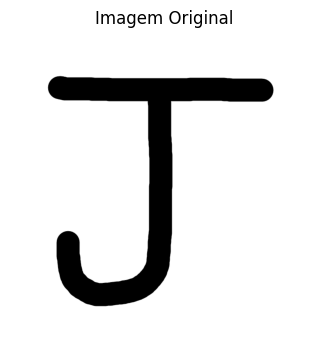

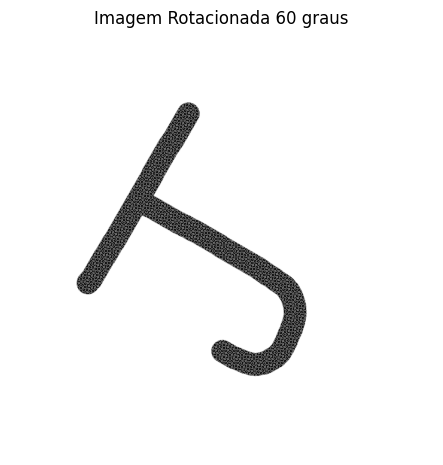

In [6]:
imagemRotacionada = rotacionarImagem(imagemOriginal, 60, True)
salvarImagem(imagemRotacionada, "results/j_rotated.png")
exibirImagem(imagemOriginal, "Imagem Original", (4,4))
exibirImagem(imagemRotacionada, "Imagem Rotacionada 60 graus", (5.5,5.5))

#### 1.3 Reflexão

A transformação de Reflexão está associada a mudança de coordenadas em torno de um eixo o qual funciona como um espelho. Perceba que esse espelho é definido pela reta gerada por um vetor $v = (a,b)$ e a Matriz de Reflexão se contrói da seguinte forma:

$$
Ref = \frac{1}{a^2+b^2}\begin{pmatrix}
a^2-b^2 & 2ab \\
2ab & b^2-a^2
\end{pmatrix}
$$


In [7]:
# transformação de reflexão
def refletirImagem(imagem: np.ndarray, espelho: np.ndarray, ehColorido: bool) -> np.ndarray:
    '''
    Função que recebe uma matriz representando uma imagem, um vetor representando o espelho
    de reflexão e um booleano indicando se a imagem é colorida ou não e realiza a reflexão
    dessa imagem sobre o espelho
    '''
    # matriz de reflexão
    a, b = espelho[0], espelho[1]       # coordenadas do espelho
    Ref = np.array([[a**2 - b**2, 2*a*b],
                    [2*a*b, b**2 - a**2]]) / (espelho @ espelho)
    
    # verificamos se o espelho é um dos eixos
    eixos = False
    xEixo = np.array([1,0])
    yEixo = np.array([0,1])
    if np.array_equal(espelho, xEixo) or np.array_equal(espelho, yEixo):
        eixos = True

    # estruturamos a matriz transformada
    numLinhas, numColunas = imagem.shape[:2]
    diagonal = ceil(sqrt(numLinhas ** 2 + numColunas ** 2))

    if ehColorido:
        if eixos: # Matriz possui as mesmas dimensões da matriz original
            numLinhasNovo, numColunasNovo = numLinhas, numColunas
            matrizRefletida = np.full((numLinhasNovo, numColunasNovo, imagem.shape[2]), (255, 255, 255, 0), dtype=imagem.dtype)
        else: # Nesse caso a matriz final terá as dimensões da diagonal
            numLinhasNovo, numColunasNovo = diagonal, diagonal
            matrizRefletida = np.full((numLinhasNovo, numColunasNovo, imagem.shape[2]), (255, 255, 255, 0), dtype=imagem.dtype)
    else:
        if eixos: # Matriz possui as mesmas dimensões da matriz original
            numLinhasNovo, numColunasNovo = numLinhas, numColunas
            matrizRefletida = 255 * np.ones((numLinhasNovo, numColunasNovo), dtype=imagem.dtype)
        else: # Nesse caso a matriz final terá as dimensões da diagonal
            numLinhasNovo, numColunas = diagonal, diagonal
            matrizRefletida = 255 * np.ones((numLinhasNovo, numColunasNovo), dtype=imagem.dtype)

    # calculamos os centros das imagens original e nova
    xcOriginal, ycOriginal = numColunas // 2, numLinhas // 2
    xcNovo, ycNovo = numColunasNovo // 2, numLinhasNovo // 2

    # aplicamos a transformação a cada pixel
    for y in range(numLinhas):
        for x in range(numColunas):
            # armazenamos o pixel da coordenada
            pixel = imagem[y, x]
            # criamos o vetor da posição relativa ao centro
            v = np.array([x - xcOriginal, y - ycOriginal])
            # aplicamos a reflexão no vetor v
            r = Ref @ v
            # obtemos as novas coordenas relativas ao novo centro
            novaLinha, novaColuna = int(r[1] + ycNovo), int(r[0] + xcNovo)
            # para garantir que as coordenadas estejam dentro dos limites
            novaLinha = np.clip(novaLinha, 0, numLinhasNovo - 1)
            novaColuna = np.clip(novaColuna, 0, numColunasNovo - 1)
            # posicionamos na nova matriz o pixel novamente
            matrizRefletida[novaLinha, novaColuna] = pixel

    return matrizRefletida

Abaixo o resultado da reflexão da imagem orginal em torno do eixo horizontal

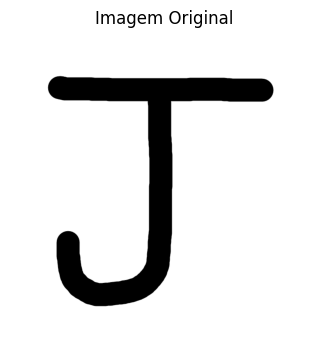

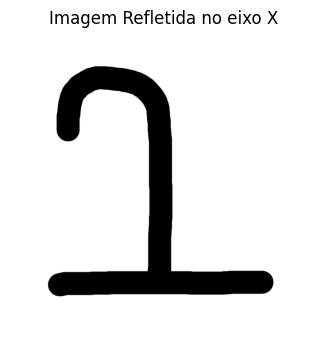

In [8]:
imagemRefletida = refletirImagem(imagemOriginal, np.array([1,0]), True)
salvarImagem(imagemRefletida, "results/j_reflected.png")
exibirImagem(imagemOriginal, "Imagem Original", (4,4))
exibirImagem(imagemRefletida, "Imagem Refletida no eixo X", (4,4))

#### 1.4 Cisalhamento

A tranformação linear de Cisalhamento está associada ao esticamento de uma dimensão de um vetor, enquanto a outra se mantém inalterada. A transformação que faremos é um cisalhamento no eixo x sob o fator $mx$. Sendo assim, a matriz dessa transformação é a seguinte:

$$
C = \begin{pmatrix}
1 & mx \\
0 & 1
\end{pmatrix}
$$

In [9]:
# transformação de cisalhamento
def cisalharImagem(imagem: np.ndarray, mx: float, ehColorido: bool) -> np.ndarray:
    '''
    Função que recebe uma matriz representando uma imagem, um fator mx representando o alongamento
    no eixo x e um booleano indicando se a imagem é colorida ou não, e realiza o cisalhamento 
    horizontal dessa imagem com o fator mx.
    '''
    # matriz de cisalhamento
    C = np.array([[1, -mx],
                  [0, 1]])

    # estruturamos a matriz transformada
    numLinhas, numColunas = imagem.shape[:2]
    numLinhasNovo, numColunasNovo = numLinhas, ceil(numColunas + (numLinhas - 1) * abs(mx))

    if ehColorido:
        matrizCisalhada = np.full((numLinhasNovo, numColunasNovo, imagem.shape[2]), (255, 255, 255, 0), dtype=imagem.dtype)
    else:
        matrizCisalhada = 255 * np.ones((numLinhasNovo, numColunasNovo), dtype=imagem.dtype)

    # calculamos os centros das imagens original e nova
    xcOriginal, ycOriginal = numColunas // 2, numLinhas // 2
    xcNovo, ycNovo = numColunasNovo // 2, numLinhasNovo // 2

    # aplicamos a transformação a cada pixel
    for y in range(numLinhas):
        for x in range(numColunas):
            # armazenamos a informação da cor
            pixel = imagem[y, x]
            # criamos o vetor v com a posição relativa ao centro
            v = np.array([x - xcOriginal, y - ycOriginal])
            # aplicamos a rotação no vetor v 
            r = C @ v
            # convertemos as novas coordenadas para inteiro e somamos ao centro da nova imagem
            novaLinha, novaColuna = int(r[1] + ycNovo), int(r[0] + xcNovo)
            # para garantir que as coordenadas estejam dentro dos limites
            novaLinha = np.clip(novaLinha, 0, numLinhasNovo - 1)
            novaColuna = np.clip(novaColuna, 0, numColunasNovo - 1)
            # colocamos o pixel na nova coordenada
            matrizCisalhada[novaLinha, novaColuna] = pixel
    
    return matrizCisalhada

Abaixo o resultado de um cizalhamento sob um fator de 0.5 no eixo x

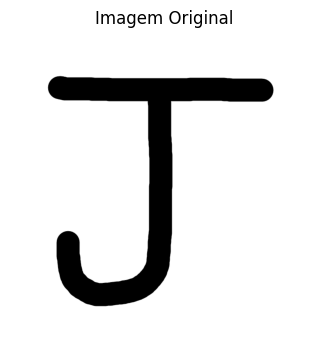

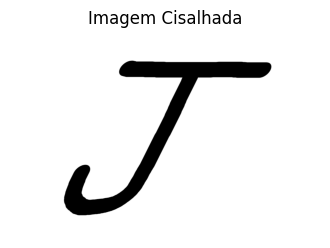

In [10]:
imagemCisalhada = cisalharImagem(imagemOriginal, 0.5, True)
salvarImagem(imagemCisalhada, "results/j_sheared.png")
exibirImagem(imagemOriginal, "Imagem Original", (4,4))
exibirImagem(imagemCisalhada, "Imagem Cisalhada", (4,4))

### 2. Aplicações Extras

#### 2.1 Esticamento com Interpolação Bilinear

Essencialmente essa aplicação faz uso da mesma transformação linear explorada no item 1.1, de esticamento, porém tentarei evitar os pixels vazios na imagem esticada através da aplicação de um Interpolação Bilinear nos pontos vazios para assim a imagem resultante ainda possui o preenchimento natural que a imagem original também tinha. 

Haja vista isso, a ideia da interpolação linear é que, após uma transformação de esticamento, queremos determinar a cor de um pixel na nova imagem. Para isso, aplicamos a transformação inversa e descobrimos que a posição correspondente na imagem original é P = (x, y). Geralmente, x e y não são números inteiros.

O ponto P está dentro de um quadrado formado por quatro pixels da imagem original. Vamos chamá-los de:

- ``pixel1`` $ = (x_1, y_1)$: Canto inferior esquerdo
- ``pixel2`` $ = (x_1, y_2)$: Canto superior esquerdo
- ``pixel2`` $ = (x_2, y_1)$: Canto inferior direito
- ``pixel2`` $ = (x_2, y_2)$: Canto superior direito

Onde $x_1 = \lfloor x \rfloor, x_2=x_1+1, y_1 = \lfloor y \rfloor, y_2 = y_1 + 1$

Além disso sejam $dx$ e $dy$ as distâncias entre $x$ e $x_1$, e $y$ e $y_1$, respectivamente.

Dessa forma a interpolação Bilinear se dá com a aplicação da Interpolação Linear nas direções x e y. Assim sendo aplicamos a interpolação na linha superior (entre ``pixel1`` e ``pixel2``) e após isso aplicamos na linha inferior (entre ``pixel3`` e ``pixel4``)

Etapa 1: Interpolação na direção X

Primeiro, interpolamos os valores ao longo do eixo x para a linha superior (``y1``) e para a linha inferior (``y2``).

1. Interpolação na linha superior (entre ``pixel1`` e ``pixel2``):

    Vamos chamar o resultado de $V_{sup}$ (Valor Superior).

$$
V_{sup} = (1 - dx) \cdot pixel1 + dx \cdot pixel2
$$

2. Interpolação na linha inferior (entre ``pixel3`` e ``pixel4``)

    Vamos chamar o resultado de $V_{inf}$ (Valor inferior).

$$
V_{inf} = (1 - dx) \cdot pixel3 + dx \cdot pixel4
$$

Etapa 2: Interpolação na direção Y

Agora, usamos os dois valores intermediários ($V_{sup}$ e $V_{inf}$) para fazer a interpolação final ao longo do eixo y e encontrar o valor final do pixel.
Vamos chamar o resultado final de $P_{final}$.

$$
P_{final} = (1 - dy) \cdot V_{sup} + dy \cdot V_{inf}
$$

Assim sendo o valor resultante da interpolação será:
$$
P_{\text{final}} = (1 - dx)(1 - dy) \cdot \text{pixel1} + dx(1 - dy) \cdot \text{pixel2} + (1 - dx)dy \cdot \text{pixel3} + dx \cdot dy \cdot \text{pixel4}
$$

Esta fórmula calcula o valor final do pixel (x, y) como uma soma ponderada dos quatro vizinhos, onde os pesos (termos como dx) representam a área do retângulo oposto a cada pixel vizinho.

In [11]:
def interpolacaoBilinear(imagem: np.ndarray, x: float, y: float, numLinhas: int, numColunas: int) -> np.ndarray:
    """
    Função para realizar a interpolação bilinear de um pixel com coordenadas não inteiras (x, y).
    """
    x1, y1 = int(np.floor(x)), int(np.floor(y))
    x2, y2 = int(np.ceil(x)), int(np.ceil(y))

    # garantir que os índices estão dentro dos limites
    x1, y1 = np.clip(x1, 0, numColunas - 1), np.clip(y1, 0, numLinhas - 1)
    x2, y2 = np.clip(x2, 0, numColunas - 1), np.clip(y2, 0, numLinhas - 1)

    # calcula as diferenças
    dx, dy = x - x1, y - y1

    # obtemos os valores dos pixels nos 4 pontos vizinhos
    pixel1 = imagem[y1, x1]
    pixel2 = imagem[y1, x2]
    pixel3 = imagem[y2, x1]
    pixel4 = imagem[y2, x2]

    # interpolação bilinear
    return (1 - dx) * (1 - dy) * pixel1 + dx * (1 - dy) * pixel2 + (1 - dx) * dy * pixel3 + dx * dy * pixel4

In [12]:
# transformação de esticamento
def redimensionarImagemComInterpolacao(imagem: np.ndarray, kx: float, ky: float, ehColorido: bool) -> np.ndarray:
    '''
    Função que recebe a matriz de uma imagem, os fatores de esticamento/encolhimento kx e ky, e um
    booleano indicando se a imagem é colorida ou não, e realiza o redimensionamento da imagem. Além
    disso é feito interpolação bilinear nos pontos da imagem final para colorir os pixels vazios
    '''
    # matriz inversa do esticamento
    E = np.array([[1/kx, 0],
                  [0, 1/ky]])
    
    # estruturamos a matriz transformada
    numLinhas, numColunas = imagem.shape[:2]

    numLinhasNovo = ceil(numLinhas * ky)
    numColunasNovo = ceil(numColunas * kx)
    
    if ehColorido:
        matrizEsticada = np.full((numLinhasNovo, numColunasNovo, imagem.shape[2]), (255, 255, 255, 0), dtype=imagem.dtype)
    else:
        matrizEsticada = 255 * np.ones((numLinhasNovo, numColunasNovo), dtype=imagem.dtype)

    # calculamos os centros das imagens original e nova
    xcOriginal, ycOriginal = numColunas // 2, numLinhas // 2
    xcNovo, ycNovo = numColunasNovo // 2, numLinhasNovo // 2

    # aplicamos a transformação a cada pixel. utilizei y para linha e x para coluna
    # para ficar dentro do contexto de uma plano cartesiano
    for y in range(numLinhasNovo):
        for x in range(numColunasNovo):
            # armazenamos a informação da cor
            # pixel = imagem[y, x]
            # criamos o vetor v com as coordenadas do pixel
            v = np.array([x - xcNovo, y - ycNovo])
            # r é o resultado do esticamento aplicado em v
            r = E @ v
            # convertemos as novas coordenadas para inteiro
            novaLinha, novaColuna = r[1] + ycOriginal, r[0] + xcOriginal
            # colocamos o pixel na nova coordenada
            if novaColuna < numColunas and novaLinha < numLinhas:
                # Aplicar interpolação bilinear para preencher o pixel
                matrizEsticada[y, x] = interpolacaoBilinear(imagem, novaColuna, novaLinha, numLinhas, numColunas)

    return matrizEsticada

Representação da imagem esticada em 2x no eixo horizontal com a função de interpolação bilinear aplicada no procedimento.

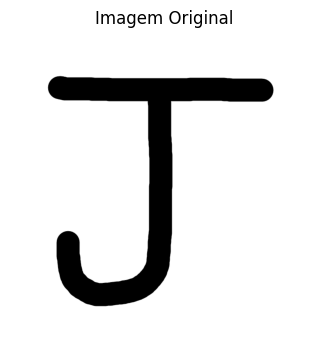

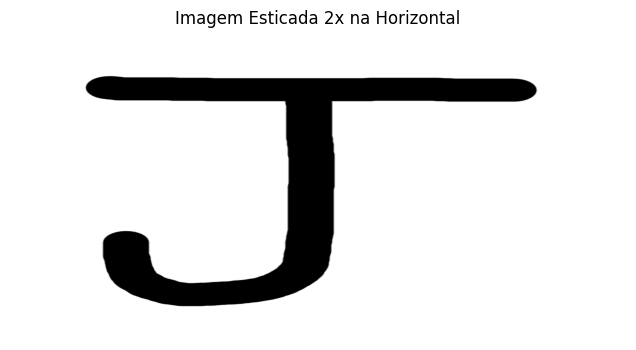

In [13]:
imagemEsticada2 = redimensionarImagemComInterpolacao(imagemOriginal, 2, 1, True)
salvarImagem(imagemEsticada2, "results/j_streched_v2.png")
exibirImagem(imagemOriginal, "Imagem Original", (4,4))
exibirImagem(imagemEsticada2, "Imagem Esticada 2x na Horizontal", (8,4))

#### 2.2 Escala Cinza

Essa não era exatamente uma Transformação Linear, porém foi uma manipulação imagens que foi recorrente durante o desenvolvimento do trabalho, o qual a transformação uma imagem colorida para uma imagem na escala de cinza

In [16]:
imagemColorida = carregarImagem("images/j_colorful.png")
imagemCinza = converterEscalaCinza(imagemColorida)
salvarImagem(imagemCinza, "results/j_gray.png")

#### 2.3 Reflexão com diagonalização

Dentre as aplicações principais estavam a de Reflexão, na qual faziamos uso da sua fórmula direta através das coordenadas do eixo de reflexão $v=(a,b)$. Porém, um conceito muito importante na álgebra linear é a de diagonalização, e ele pode ser muito bem explorado para obter a transformação de reflexão. A ideia primordial aqui será diagonalizar a reflexão em uma reta gerada pelo vetor $v$, que faz um angulo $\theta$ com o eixo x, através de uma rotação do sistema de coordenadas, uma reflexão simples no eixo x e uma ultima rotação para o sistema de coordenadas original. Alinhado a esses conceitos estão fundamentos de autovetores e autovalores. A formula da diagonalização se dá então como:

$$
Rot(\theta) = \begin{pmatrix}
\cos(\theta) & \sin(\theta) \\
-\sin(\theta) & \cos(\theta)
\end{pmatrix}
$$

$$
Ref_x = \begin{pmatrix}
1 & 0 \\
0 & -1
\end{pmatrix}
$$

$$
Ref_{\theta} = Rot(-\theta) \cdot Ref_x \cdot Rot(\theta)
$$

Sendo assim a expressão de $Ref_{\theta}$ é equivalente a fórmula de reflexão das aplicações principais, porém de forma diagonalizada. Abaixo está desenvolvido o código dessa forma de enxergar a transformação.

In [17]:
# transformação de reflexão
def refletirImagemComDiagonalizacao(imagem: np.ndarray, espelho: np.ndarray, ehColorido: bool) -> np.ndarray:
    '''
    Função que recebe uma matriz representando uma imagem, um vetor representando o espelho
    de reflexão e um booleano indicando se a imagem é colorida ou não e realiza a reflexão
    dessa imagem sobre o espelho
    '''
    # matriz de reflexão
    a, b = espelho[0], espelho[1]       # coordenadas do espelho
    angulo = np.arctan2(b,a)

    Rot = np.array([[np.cos(angulo), np.sin(angulo)],   # Matriz de Rotacão para voltar ao angulo original
                    [-np.sin(angulo), np.cos(angulo)]])
    
    RotInv = np.array([[np.cos(angulo), -np.sin(angulo)],   # Matriz de Rotação inversa para levar o eixo
                       [np.sin(angulo),  np.cos(angulo)]])  # para os canônicos
    
    A = np.array([[1, 0],   # Matriz com os autovalores da Reflexão
                  [0,-1]])
    Ref = Rot @ A @ RotInv  # Diagonalização da matriz de reflexão
    
    # verificamos se o espelho é um dos eixos
    eixos = False
    xEixo = np.array([1,0])
    yEixo = np.array([0,1])
    if np.array_equal(espelho, xEixo) or np.array_equal(espelho, yEixo):
        eixos = True

    # estruturamos a matriz transformada
    numLinhas, numColunas = imagem.shape[:2]
    diagonal = ceil(sqrt(numLinhas ** 2 + numColunas ** 2))

    if ehColorido:
        if eixos: # Matriz possui as mesmas dimensões da matriz original
            numLinhasNovo, numColunasNovo = numLinhas, numColunas
            matrizRefletida = np.full((numLinhasNovo, numColunasNovo, imagem.shape[2]), (255, 255, 255, 0), dtype=imagem.dtype)
        else: # Nesse caso a matriz final terá as dimensões da diagonal
            numLinhasNovo, numColunasNovo = diagonal, diagonal
            matrizRefletida = np.full((numLinhasNovo, numColunasNovo, imagem.shape[2]), (255, 255, 255, 0), dtype=imagem.dtype)
    else:
        if eixos: # Matriz possui as mesmas dimensões da matriz original
            numLinhasNovo, numColunasNovo = numLinhas, numColunas
            matrizRefletida = 255 * np.ones((numLinhasNovo, numColunasNovo), dtype=imagem.dtype)
        else: # Nesse caso a matriz final terá as dimensões da diagonal
            numLinhasNovo, numColunas = diagonal, diagonal
            matrizRefletida = 255 * np.ones((numLinhasNovo, numColunasNovo), dtype=imagem.dtype)

    # calculamos os centros das imagens original e nova
    xcOriginal, ycOriginal = numColunas // 2, numLinhas // 2
    xcNovo, ycNovo = numColunasNovo // 2, numLinhasNovo // 2

    # aplicamos a transformação a cada pixel
    for y in range(numLinhas):
        for x in range(numColunas):
            # armazenamos o pixel da coordenada
            pixel = imagem[y, x]
            # criamos o vetor da posição relativa ao centro
            v = np.array([x - xcOriginal, y - ycOriginal])
            # aplicamos a reflexão no vetor v
            r = Ref @ v
            # obtemos as novas coordenas relativas ao novo centro
            novaLinha, novaColuna = int(r[1] + ycNovo), int(r[0] + xcNovo)
            # para garantir que as coordenadas estejam dentro dos limites
            novaLinha = np.clip(novaLinha, 0, numLinhasNovo - 1)
            novaColuna = np.clip(novaColuna, 0, numColunasNovo - 1)
            # posicionamos na nova matriz o pixel novamente
            matrizRefletida[novaLinha, novaColuna] = pixel

    return matrizRefletida

Abaixo está o resultado da imagem refletida no eixo vertical

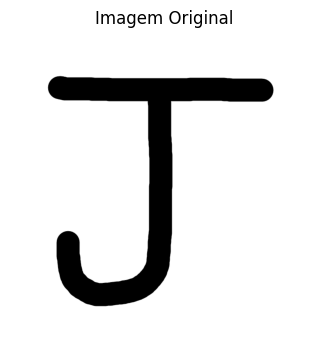

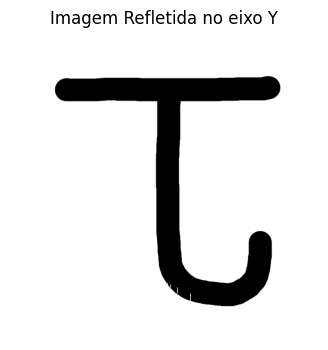

In [18]:
imagemRefletida2 = refletirImagemComDiagonalizacao(imagemOriginal, np.array([0,1]), True)
salvarImagem(imagemRefletida2, "results/j_reflected_v2.png")
exibirImagem(imagemOriginal, "Imagem Original", (4,4))
exibirImagem(imagemRefletida2, "Imagem Refletida no eixo Y", (4,4))

# Relatório

## Bibliotecas Utilizadas

Para a realização deste trabalho, foram utilizadas as seguintes bibliotecas:

- `numpy`: Para manipulação de matrizes e operações matemáticas.
- `Pillow`: Para importação e manipulação de imagens.
- `matplotlib`: Para exibição das imagens.
- `math`: Para funções matemáticas adicionais.

## Transformações Lineares Realizadas

### 1. Esticamento

A transformação de esticamento foi aplicada utilizando uma matriz de esticamento. A função `redimensionarImagem` foi responsável por essa transformação, onde os fatores de esticamento `kx` e `ky` foram aplicados nas direções horizontal e vertical, respectivamente. A matriz resultante teve suas dimensões alteradas de acordo com os fatores de esticamento.

### 2. Rotação

A transformação de rotação foi realizada utilizando uma matriz de rotação. A função `rotacionarImagem` aplicou a rotação em um ângulo especificado. A matriz resultante teve suas dimensões ajustadas para acomodar a imagem rotacionada, considerando a diagonal da imagem original como maior valor possivel.

### 3. Reflexão

A transformação de reflexão foi aplicada utilizando uma matriz de reflexão. A função `refletirImagem` realizou a reflexão da imagem sobre um espelho especificado. A matriz resultante teve suas dimensões ajustadas de acordo com a necessidade da reflexão. No caso, quando a reflexão era sobre algum dos eixos, a nossa imagem final não sofre nenhuma alteração de tamanho, então manteve-se as mesmas dimensões. Para o caso de um eixo arbitrário qualquer, a dimensão da imagem final foi considerada a da diagonal como maior valor possível

### 4. Cisalhamento

A transformação de cisalhamento foi realizada utilizando uma matriz de cisalhamento. A função `cisalharImagem` aplicou o cisalhamento horizontal na imagem com um fator `mx`. A matriz resultante teve suas dimensões ajustadas para acomodar a imagem cisalhada.

## Aplicações Extras

### 1. Conversão para Escala de Cinza

Foi implementada uma função `converterEscalaCinza` para converter a imagem original em uma imagem em escala de cinza, através do produto interno entre os coeficientes da escala cinza com os devidos valores de vermelho, verde, azul e opacidade dos pixels. A matriz resultante teve suas dimensões mantidas, mas com valores de intensidade de cinza.

### 2. Reflexão com Diagonalização

Foi implementada uma função `refletirImagemComDiagonalizacao` que utilizou a diagonalização da matriz de reflexão para realizar a transformação. A matriz resultante teve suas dimensões ajustadas de acordo com a necessidade da reflexão. No caso, quando a reflexão era sobre algum dos eixos, a nossa imagem final não sofre nenhuma alteração de tamanho, então manteve-se as mesmas dimensões. Para o caso de um eixo arbitrário qualquer, a dimensão da imagem final foi considerada a da diagonal como maior valor possível

## Problema de Pixels Vazios e Solução com Interpolação

Ao aplicar as algumas transformações lineares, foi percebido um problema com a presença de pixels vazios na imagem resultante. Para solucionar esse problema, foi implementada uma função de interpolação bilinear. A função `redimensionarImagemComInterpolacao` utilizou a interpolação bilinear para preencher os pixels vazios para a transformação de esticamento, resultando em uma imagem esticada sem espaços em branco.

## Conclusão

As transformações lineares aplicadas permitiram explorar diferentes manipulações de imagens, ajustando suas dimensões e orientações. A aplicação de interpolação bilinear foi essencial para resolver o problema de pixels vazios, garantindo uma melhor qualidade nas imagens esticadas.